**Main objective of the analysis**

train classification model on the dataset to detect if the patient have diabeties or not

**Brief description of the data set**

The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, 
The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.It has a total of 768 rows and 9 columns

| S No. | Column | Description| Data Type | Category| Type
| --- | --- | --- | --- | --- | --- |
|1 | Pregnancies | Number of times pregnant | Int | Discrete | Variable |
|2 | Glucose | Plasma glucose concentration a 2 hours in an oral glucose tolerance test | Int | Discrete | Variable |
|3 | Blood pressure | Diastolic blood pressure (mm Hg) | Int | Discrete | Variable |
|4 |Skin thickness | Triceps skin fold thickness (mm) | Int | Discrete | Variable |
|5 | Insulin | 2-Hour serum insulin (mu U/ml) | Int | Discrete | Variable |
|6 | BMI | Body mass index (weight in kg/(height in m)^2) | Float | Continuous | Variable |
|7 | DiabetesPedigreeFunction | Diabetes pedigree function| Float | Continuous | Variable |
|8 | Age | Age (years) | Int | Discrete | Variable |
|9 | Outcome | Class variable (0 or 1)| Int | Discrete | Target |

**Plan for Data Exploration, Feature Engineering and Modelling**

The steps in solving the Regression Problem are as follows:
1. Packages to be installed
2. Load the libraries
3. Load the dataset
4. General information about the dataset
5. Exploratory Data Analysis (EDA)
6. Modeling
7. Recommendations

## Packages to be installed

1. autokeras
2. Auto-PyTorch

In [1]:
#!pip install autokeras

## Load the libraries

1. numpy
2. pandas
3. matplotlib
4. seaborn
5. sklearn
6. autokeras
7. autopytorch
8. tqdm
9. tensorflow
10. pickle

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.utils import parallel_backend
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import pprint
import pickle
from tensorflow.keras.constraints import max_norm
import gc
from tensorflow.keras import mixed_precision
import autokeras as ak
import autoPyTorch
#import warnings
#warnings.filterwarnings("ignore")
import logging

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Load the dataset

location of dataset

In [3]:
dataset = 'https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv'

reading the dataset into dataframe

In [4]:
df = pd.read_csv(dataset)

## General information about the dataset

sampling the data

In [5]:
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


number of rows and coulmns in dataset

In [6]:
print(df.shape)

(768, 9)


dataset information

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


**Actions taken for data cleaning and feature engineering**

Capitalize column names

In [8]:
df.columns = df.columns.str.capitalize()

Classifying columns as Numerical or Categorical

In [9]:
num_cols = df.select_dtypes('number').columns.tolist()

Features Encoding

In [10]:
sc = MinMaxScaler()
df2 = df.iloc[:,:-1]
num_features = num_cols[:-1]
df2[num_features] = sc.fit_transform(df2[num_features])

 Split the data into test and train

In [11]:
features = df2.columns
target = df.columns[-1]
X = df2
Y = df[target]
sss = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=0)
train_indecies = list(sss.split(X,y=Y))
train_index, test_index = train_indecies[0][0], train_indecies[0][1]
X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = Y.loc[train_index], Y.loc[test_index]
X_train, X_test = np.float16(X_train), np.float16(X_test)
y_train, y_test = np.float16(y_train), np.float16(y_test)

In [12]:
# from keras.utils import np_utils
# nb_classes = 10
# Y_train = np_utils.to_categorical(y_train, nb_classes)
# Y_test = np_utils.to_categorical(y_test, nb_classes)

## Exploratory Data Analysis (EDA)

Summary Statistics for Numerical columns

In [13]:
print(df.describe())

       Pregnancies     Glucose  Bloodpressure  Skinthickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              Bmi  Diabetespedigreefunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

Visual Exploration of Numerical Columns

Distribution of Age for patients

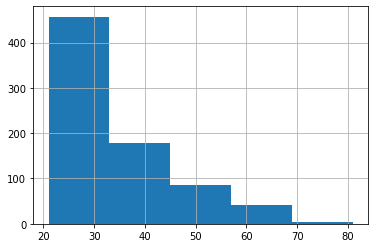

In [14]:
df['Age'].hist(bins=5);

Correlation between Age and BMI

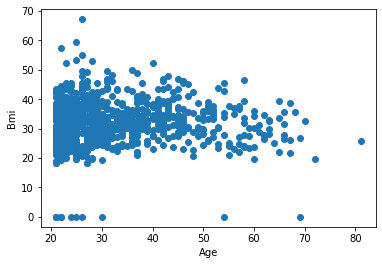

In [15]:
x = df['Age']
y = df['Bmi']
plt.scatter(x,y)
plt.xlabel('Age')
plt.ylabel('Bmi');

Visual Exploration of Categorical columns

Count No. of pregnancies

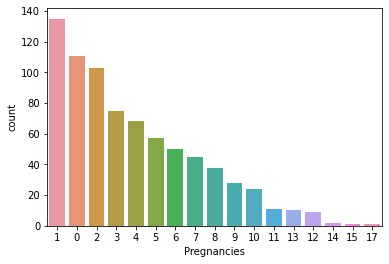

In [16]:
sns.countplot(data=df, x='Pregnancies',order=df['Pregnancies'].value_counts().index);

Distribution of Pregnancies for each BMI category

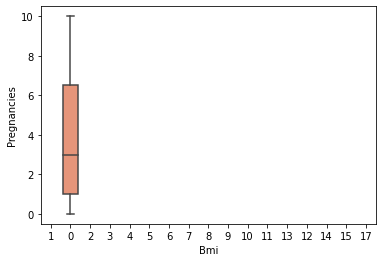

In [17]:
sns.boxplot(y=df['Pregnancies'], x=df['Bmi'],order=df['Pregnancies'].value_counts().index);

Pair plot of numerical features

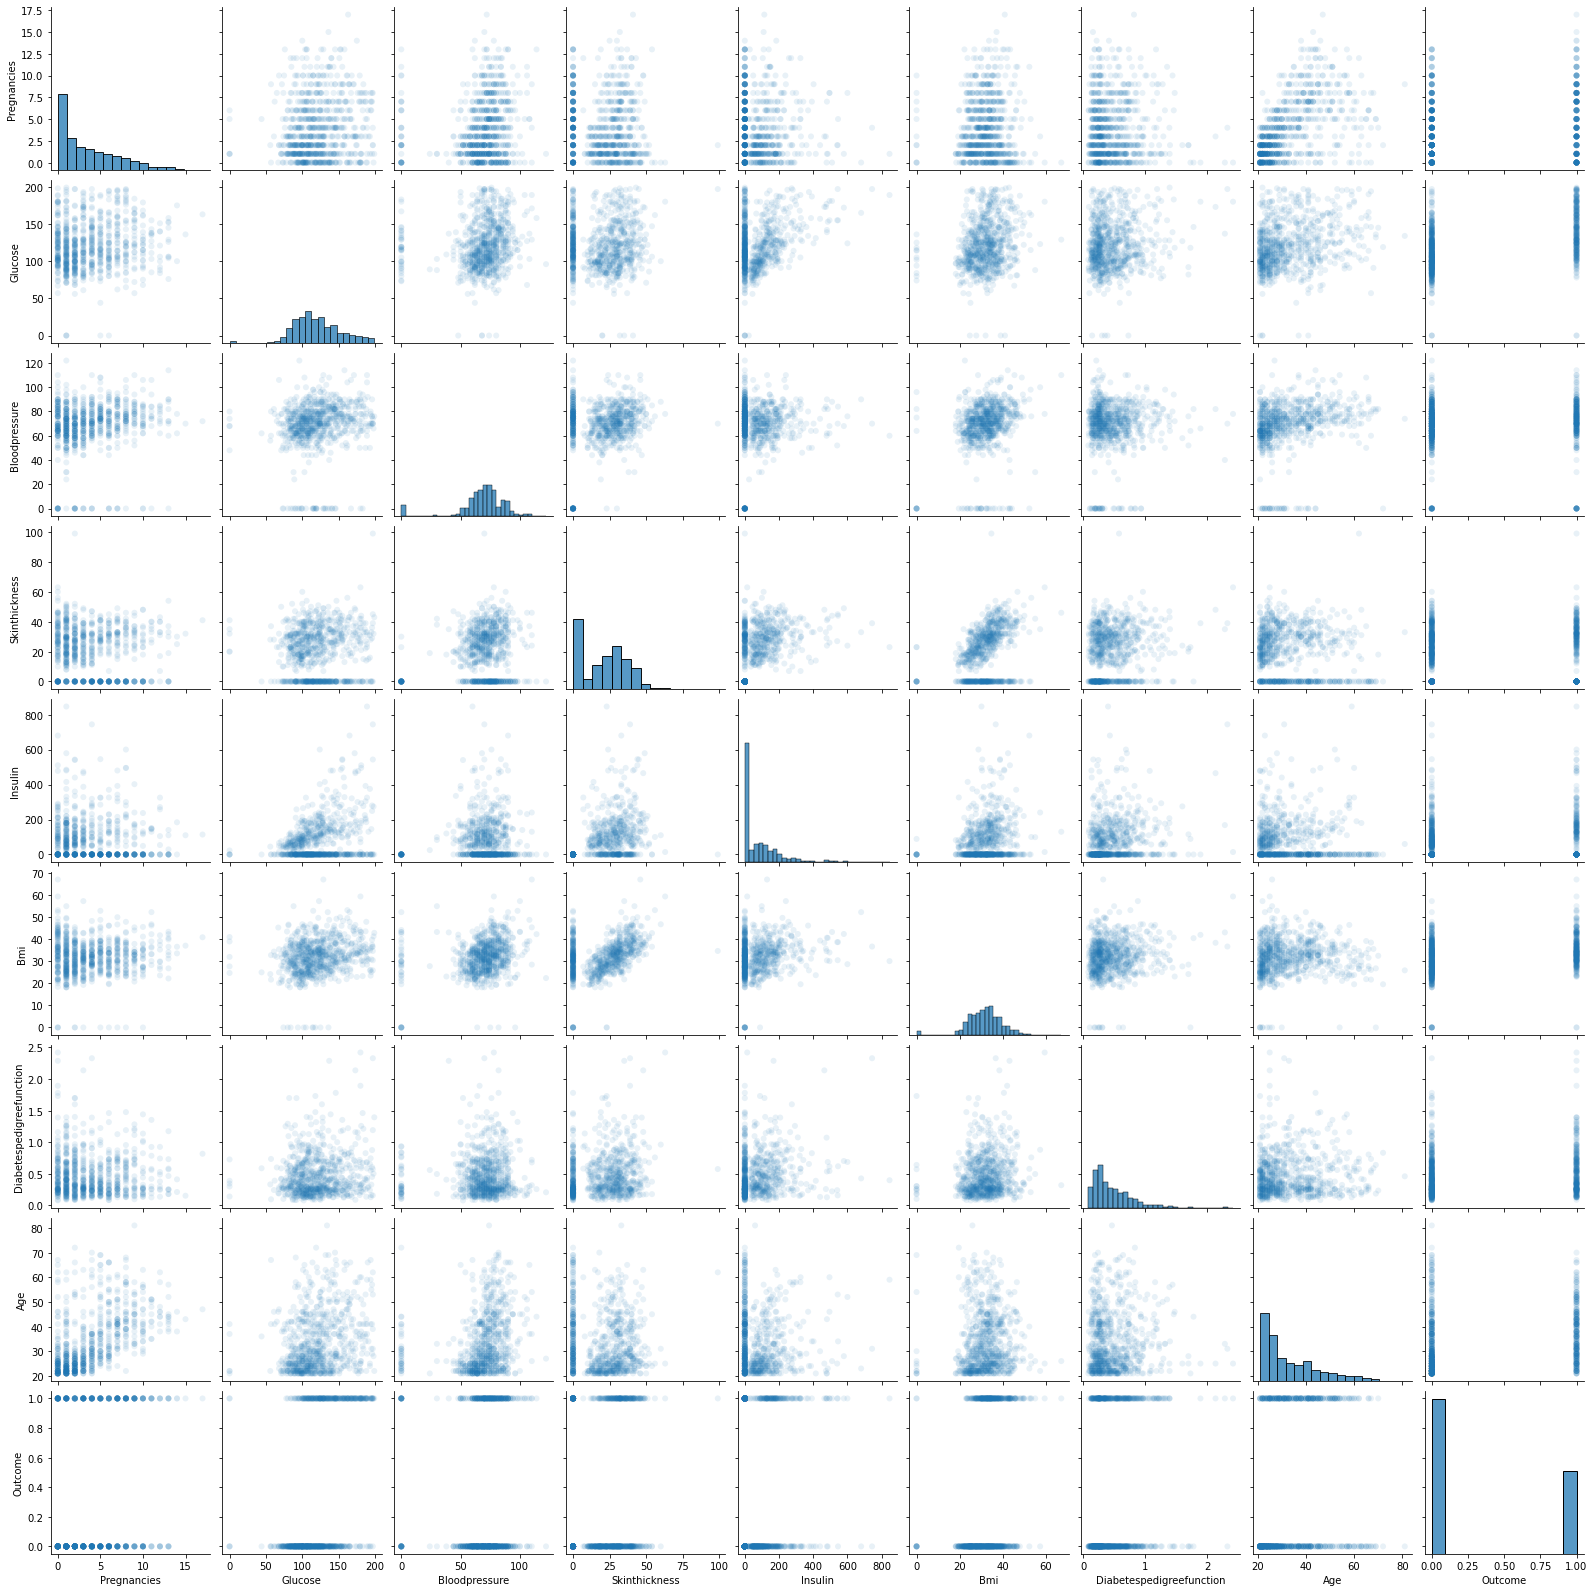

In [18]:
sns.pairplot(df[num_cols], plot_kws=dict(alpha=.1, edgecolor='none'));

heatmap of numerical features

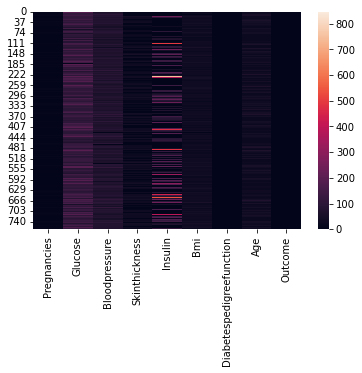

In [19]:
sns.heatmap(df[num_cols]);

correlation plot of numerical features

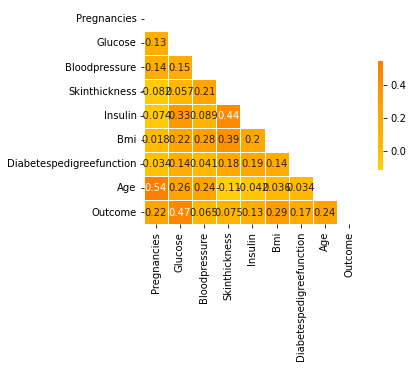

In [20]:
corr = df.corr()
mask = np.triu(corr)
sns.heatmap(corr, mask=mask, cmap='Wistia', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5},  annot= True);

Feature Importance

                    Feature  Feature_importance %
1                   Glucose             29.125143
7                       Age             14.963818
5                       Bmi             13.268242
6  Diabetespedigreefunction             10.840599
0               Pregnancies             10.328370
2             Bloodpressure              8.427524
4                   Insulin              6.668139
3             Skinthickness              6.378164


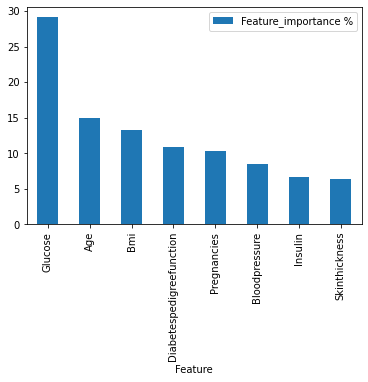

In [21]:
fe = ExtraTreesRegressor(n_estimators=10)
fe.fit(X, Y)
fedf = pd.DataFrame({'Feature':features,'Feature_importance %' : fe.feature_importances_ * 100})
fedf = fedf.sort_values(by=['Feature_importance %'], ascending=False)
print(fedf)
fedf.plot.bar(x='Feature',y='Feature_importance %');

## Modeling

**Modelling  Task Details**

| S No. | Description| Category| Type |
| --- | --- | --- | --- | 
|1 | Data being used| Structured | Categorical |
|2 | Machine learning problem | Classification |  Binary-class |
|3 | Relevant ML and DL models | Deep Learning | DNNs |
|4 | Technical metrics | Accuracy | Percentage (the higher the better) |
|5 | Hyperparameter optimization techniques | Grid search | Specified Dictionary |
|6 | Computation method | Cloud | TPU | 
|7 | Additional Features | Callback | Memory garbage collection | 

we will be training deep neural networks from the Tensorflow library and the comparing them according to accuracy on the testing dataset

In [22]:
# code for setting TPU or GPU for keras training
# try:
#     tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
#     mixed_precision.set_global_policy('mixed_bfloat16')
#     os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
#     os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
# except ValueError:
#     tpu_resolver = None
#     gpus = tf.config.experimental.list_logical_devices("GPU") # GPU detection
#     mixed_precision.set_global_policy('mixed_float16')
#     os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
#     os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

# # Select appropriate distribution strategy
# if tpu_resolver:
#     tf.config.experimental_connect_to_cluster(tpu_resolver)
#     tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
#     strategy = tf.distribute.TPUStrategy(tpu_resolver)
#     print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
# elif len(gpus) > 1:
#     strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
#     print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
# elif len(gpus) == 1:
#     strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
#     print('Running on single GPU ', gpus[0].name)
# else:
#     strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
#     print('Running on CPU')
#     os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
#     os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#     print("Number of accelerators: ", strategy.num_replicas_in_sync)

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Running on CPU
Number of accelerators:  1


2021-11-05 04:17:08.951530: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-05 04:17:08.951592: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-05 04:17:08.951630: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ad410gadwde2): /proc/driver/nvidia/version does not exist
2021-11-05 04:17:08.953305: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
# GRIDSERACH for KERAS NN
# checkpoint = ModelCheckpoint('gridsearchnnmodel.hdf5', monitor='accuracy', verbose=0, save_best_only=True, mode='max')

# class CleanMemory(Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         gc.collect()
#         k.clear_session()

# clean_memory = CleanMemory()


# # batch_size=1024 # 128*8 for a TPU with 8 cores
# # steps_per_execution=64 # 8 per core
# # cls_loss = ["binary_crossentropy","categorical_crossentropy","sparse_categorical_crossentropy","poisson","kl_divergence"]
# # reg_loss = ["mean_squared_error","mean_absolute_error","mean_absolute_percentage_error","mean_squared_logarithmic_error","cosine_similarity","huber_loss"]



# A = divisors(X_train.shape[0])[1:-1]
# steps_per_epoch= A[:len(A)//2]
# batch_size = A[len(A)//2:][1:]
# epochs = [30,50,100]
# optimizer = ['sgd','rmsprop','adagrad','adadelta','adam','adamax','nadam','ftrl']
# init_mode = ['constant','glorot_normal','glorot_uniform','he_normal','he_uniform','identity','lecun_normal','lecun_uniform','ones','orthogonal','random_normal','random_uniform','truncated_normal','variance_scaling','zeros']
# activations = [sigmoid,elu,gelu,linear,relu,selu,softmax,softplus,softsign,LeakyReLU(), PReLU(), ThresholdedReLU()]
# weight_constraints = np.array([0,1,2,3,4,5])
# regularizations = [Dropout, GaussianDropout, AlphaDropout]
# normalizations = [LayerNormalization(),BatchNormalization()]
# kernel_constraints = [max_norm, min_max_norm, non_neg, unit_norm, radial_constraint]
# dropout_rates = np.array([0.1*i for i in range(0,10)])
# neurons = np.array([2**i for i in range(4,11)])
# hidden_layers = np.array([1])
# regularizers = [l1, l2, l1_l2]
# reg_coef = [10**i for i in range(-2,-5,-1)]
# regularizer_with_coef = [i(j) if i in [l1,l2] else i(j,k) for i in regularizers for j in reg_coef for k in reg_coef]
# regularizer_with_coef = regularizer_with_coef[0:18:3] + regularizer_with_coef[18:]
# losses=["binary_crossentropy","categorical_crossentropy","sparse_categorical_crossentropy","poisson","kl_divergence"]
# param_grid = dict(optimize=optimizers,imode=init_modes,
#                   afunc=activations,
#                   wconstraint=weight_constraints, 
#                   regularize=regularizations,normalize=normalizations,
#                   kconstraint=kernel_constraints,
#                   drate=dropout_rates,neurons=neurons,hiddenlayers=hidden_layers,
#                   regularizer_with_coef=regularizer_with_coef,
#                   lossfunc=losses,
#                   epochs=epochs,steps_per_epoch=steps_per_epoch,batch_size=batch_size)


# def create_model(optimize='adam', imode='uniform', afunc=sigmoid,
#                  wconstraint=0, regularize=Dropout,
#                  normalize=BatchNormalization(), kconstraint=max_norm,
#                  drate=0.5, neurons=2, hiddenlayers=1, regularizer_with_coef=l1(0.0001),  lossfunc='binary_crossentropy'):
#     with strategy.scope():
#         model = Sequential()
#         model.add(InputLayer(input_shape=(X_train.shape[1],)))
#         for n_inner in range(hiddenlayers):
#             model.add(normalize)
#             model.add(Dense(neurons, kernel_initializer=imode, activation=afunc,
#             kernel_regularizer=regularizer_with_coef,
#             bias_regularizer=regularizer_with_coef,
#             activity_regularizer=regularizer_with_coef,
#             kernel_constraint=kconstraint(wconstraint)))
#             model.add(regularize(drate))
#         model.add(Dense(1, activation='sigmoid'))
#         model.compile(loss=lossfunc, optimizer=optimize, metrics=['accuracy'])
#         return model


# estimator = KerasClassifier(build_fn=create_model,verbose=1)
# grid = GridSearchCV(cv=2,estimator=estimator,param_grid=param_grid,n_jobs=-1,refit=True,error_score=0,
#                            return_train_score=False,verbose=1)# ,aggressive_elimination=True,factor=2,min_resources=X_train.shape[0]); for HalvingGridSearchCV
# grid_result = grid.fit(X_train, y_train,callbacks=[checkpoint,clean_memory],shuffle=True);

Fitting 2 folds for each of 3317760 candidates, totalling 6635520 fits


2021-11-05 04:17:23.603685: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-05 04:17:23.603683: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-05 04:17:23.603686: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-05 04:17:23.629280: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


KeyboardInterrupt: 

In [ ]:
models=[]
test_scores=[]

checkpoint = ModelCheckpoint('gridsearchnnmodel.h5', monitor='accuracy', verbose=0, save_best_only=True, mode='max')

model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dense(X_train.shape[1], kernel_initializer='glorot_normal', activation='elu',
                kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01),
                bias_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01),
                activity_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01),
kernel_constraint=max_norm(0)))
model.add(Dropout(0))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=122,epochs = 100,
                       steps_per_epoch = 5,verbose=0,callbacks=[checkpoint],shuffle=True);
loss, smscore = model.evaluate(X_test, y_test);
models.append('simpleDNNmodel')
test_scores.append(smscore)

**recommendation of final model that best fits your needs in terms of accuracy and explainability.**

Neueal Network Classifier have been fitted with the best parameters based on the grid seach

**Summary Key Findings and Insights**

* Glucose level in the blood is main factor in deciding the patient have diabities

## Recommendations

**Suggestions for next steps in analyzing this data**

using automated machine learning yield better results than manual or gridseached models

for this dataset will use autokeras and auto pytorch to compare thier results against models obtained before

In [ ]:
train_set = tf.data.Dataset.from_tensor_slices((X_train.astype(np.unicode), y_train))
test_set = tf.data.Dataset.from_tensor_slices(
    (X_test.astype(np.unicode), y_test))
akm = ak.StructuredDataClassifier(overwrite=True, max_trials=5);
akm.fit(train_set, epochs=100);
akloss, akacc = akm.evaluate(test_set);
models.append('autokerasmodel')
test_scores.append(akacc)

In [ ]:
aptm = autoPyTorch.AutoNetClassification(min_budget=20,max_budget=70,max_runtime=1200)
aptm.fit(X_train, y_train)
predictions = aptm.predict(X_test)
aptscore = accuracy_score(y_test, predictions)
with open('autopytorchmodel.pickle', 'wb') as handle:
    pickle.dump(aptm, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
models.append('autopytorchmodel')
test_scores.append(aptscore)

the default configuration for automated machine learning give better results than the model that manually selected and modified

In [ ]:
logging.getLogger('matplotlib.font_manager').disabled = True
# Compare Algorithms
results_df = pd.DataFrame({'Model':models, 'Test_Score': test_scores})
results_df = results_df.sort_values(by=['Test_Score'], ascending=False)
print(results_df)
sns.barplot(data=results_df, x='Test_Score', y='Model', orient = 'h');
plt.title('Algorithm Comparison');